# CROMA reproduction training test

The purpose of this notebook is to try to get the CROMA code training, which includes a test of the dataset loading code.

In [1]:
from pathlib import Path

import random
from scale_alibi.dataset.loader import MultimodalDataset, PMTileDataset, RemoveChannels, LoresMultimodalDataset, ChannelsFirstImageOrder

from torchvision.transforms import Compose
from pmtiles.tile import tileid_to_zxy
from matplotlib import pyplot as plt
import einops

import numpy as np

LORES_DATASET_PATH_SMALL = Path('../rasters/final/visual_tiles_small.pmtile')
RADAR_DATASET_PATH_SMALL = Path('../rasters/final/sar_tiles_small.pmtile')
HIRES_DATASET_PATH_SMALL = Path('../rasters/final/hires_visual_small.pmtile')
LORES_DATASET_PATH = Path('../rasters/final/visual_tiles.pmtile')
RADAR_DATASET_PATH = Path('../rasters/final/sar_tiles.pmtile')
HIRES_DATASET_PATH = Path('../rasters/final/hires_visual.pmtile')

## load some samples

Loading the datasets.

In [2]:
lores_dset = PMTileDataset(
    LORES_DATASET_PATH_SMALL,
    transform=Compose([
        RemoveChannels([3]), # remove alpha
        ChannelsFirstImageOrder()
    ])
)
radar_dset = PMTileDataset(
    RADAR_DATASET_PATH_SMALL,
    # transform=RemoveChannels([0,3])
    transform=Compose([
        RemoveChannels([0, 3]), # remove alpha and empty red channel
        ChannelsFirstImageOrder()
    ])
)

# hires_dset = PMTileDataset(HIRES_DATASET_PATH_SMALL)

# lores_dset_test = PMTileDataset(LORES_DATASET_PATH_SMALL)
# radar_dset_test = PMTileDataset(RADAR_DATASET_PATH_SMALL)
# hires_dset_test = PMTileDataset(HIRES_DATASET_PATH_SMALL)

In [3]:
# print('hires train tiles:', len(hires_dset))
print('lores train tiles:', len(lores_dset))
print('radar train tiles:', len(radar_dset))

# print('hires test tiles:', len(hires_dset_test))
# print('lores test tiles:', len(lores_dset_test))
# print('radar test tiles:', len(radar_dset_test))

lores train tiles: 21917
radar train tiles: 83407


In [4]:
# mmset_train = MultimodalDataset(
#     radar_dset,
#     lores_dset,
#     hires_dset
# )

mmset_train = LoresMultimodalDataset(
    radar_dset,
    lores_dset,
    # hires_dset
)

# mmset_test = MultimodalDataset(
#     radar_dset_test,
#     lores_dset_test,
#     hires_dset_test
# )

In [5]:
print('joint tiles:     ', len(mmset_train))
# print('joint test tiles:', len(mmset_test))

# print('train/test overlap', len(set(mmset_train.tile_ids) & set(mmset_test.tile_ids)))


joint tiles:      21497


In [6]:
sample = mmset_train[0]

# print(f'data shapes:\n\tradar: {sample.radar.shape}\n\tlores: {sample.lores.shape}\n\thires: {sample.hires.shape}')
print(f'data shapes:\n\tradar: {sample.radar.shape}\n\tlores: {sample.lores.shape}')#\n\thires: {sample.hires.shape}')

data shapes:
	radar: (2, 256, 256)
	lores: (3, 256, 256)


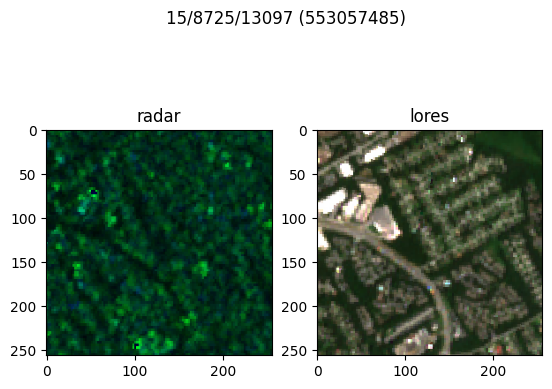

In [7]:
def show_sample(sample):
    fig, axs = plt.subplots(1,2)
    
    z,x,y = tileid_to_zxy(sample.tile_id)
    
    fig.suptitle(f'{z}/{x}/{y} ({sample.tile_id})')
    
    radar = einops.rearrange(
        sample.radar,
        'c h w -> h w c'
    )
    lores = einops.rearrange(
        sample.lores,
        'c h w -> h w c'
    )
    
    # process radar to add back in the red channel (so it's displayable)
    radar = np.stack(
        [
            np.zeros((256,256), dtype=np.uint8),
            radar[:,:,0],
            radar[:,:,1]
        ],
        axis=-1
    )
    
    axs[0].set_title('radar')
    axs[0].imshow(
        radar
    )
    
    axs[1].set_title('lores')
    axs[1].imshow(lores)
    
#     axs[2].set_title('hires')
#     axs[2].imshow(sample.hires)
    
    plt.show()

show_sample(random.choice(mmset_train))

## training loop

In [8]:
from scale_alibi.croma.pretrain_croma import CROMA, get_mask
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist

from torch.cuda.amp import GradScaler, autocast

from dataclasses import dataclass

print('distributed processing available?:', dist.is_available())

distributed processing available?: True


In [9]:
# parameters
# CromaParams = namedtuple('CromaParams', ['batch_size', 'num_patches', 'mask_ratio

@dataclass
class CromaParams:
    batch_size: int = 2
    # num_patches: int = 225 # aka sequence length (why 225?)
    mask_ratio: float = 0.4 # mask ratio (ratio of patches in a sequence to keep)
    device: str = 'cpu'
    
    epochs: int = 10
    learning_rate: float = 1e4
    total_channels: int = 5
    
    num_patches: int = 1024
    patch_size: int = 8

def setup(rank, world_size):
    # Initialize the process group
    # dist.init_process_group(backend='nccl', init_method='env://', world_size=world_size, rank=rank)

    store = dist.HashStore()
    
    # gloo for cpu
    dist.init_process_group(
        backend='gloo',
        # init_method='env://',
        store=store,
        world_size=world_size,
        rank=rank
    )
    
    return store

def cleanup():
    # Clean up the process group
    dist.destroy_process_group()


def train(rank: int, world_size: int, args: CromaParams):
    print(f'training starting with rank {rank} (world {world_size})')
    
    # for
    croma = CROMA(
        # ... defaults should be okay
        # except for total_channels, we may need to remove channels from S2,
        total_channels=5, # 2 sar, 3 lores_visual
        num_patches=args.num_patches,
        patch_size=args.patch_size
    )
    croma.to(args.device)

#     print(
#         'croma weight types',
#         croma.radar_encoder.linear_input.weight.dtype
#     )


    dataset = mmset_train #TileDataset() # ...
    
    loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
    optimizer = Adam(croma.parameters(), lr=args.learning_rate)

    

    croma = DDP(croma)

    epochs = 10
    for epoch in range(epochs):
        croma.train()  # Set the model to training mode

        for batch in loader:
            # print(batch)
            print(f'data shapes:\n\tradar: {batch.radar.shape}\n\tlores: {batch.lores.shape}')#\n\thires: {batch.hires.shape}')
            # get mask creates a mask for the MAE based on the number
            # of patches (seq_len) and a ratio of patches to keep
            seq_len = args.num_patches
            radar_mask = get_mask(
                args.batch_size,
                seq_len,
                args.device,
                args.mask_ratio
            )
            optical_mask = get_mask(
                args.batch_size,
                seq_len,
                args.device,
                args.mask_ratio
            )

            radar_imgs = batch.radar.float().to(args.device)
            lores_imgs = batch.lores.float().to(args.device)

            optimizer.zero_grad()

            # TODO : finish this
            contrastive_loss, mae_loss = croma(
                radar_imgs,
                lores_imgs,
                radar_mask,
                optical_mask,
                rank,
                world_size
            )
            
            print(contrastive_loss, mae_loss)

            break
        break
        
if not dist.is_initialized():
    store = setup(0,1)

train(0,1, CromaParams())

training starting with rank 0 (world 1)
data shapes:
	radar: torch.Size([2, 2, 256, 256])
	lores: torch.Size([2, 3, 256, 256])
tensor(0.6937, grad_fn=<DivBackward0>) tensor(2.7824, grad_fn=<AddBackward0>)


Considering this good enough for now.